In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score,
                             precision_score ,recall_score , f1_score )
from sklearn.impute import SimpleImputer
import xgboost as xgb

# Load data
df=  pd.read_csv( r'C:\Users\Sony\Desktop\Telecom Customers Churn.csv')

In [2]:
# Data Preprocessing And Feature EngIneering

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="* 80)

# Create a copy for preprocessing
df_model= df.copy()

# Handle TotalCharges (convert to numeric)
df_model['TotalCharges'] = pd.to_numeric(df_model["TotalCharges"], errors='coerce')
df_model['TotalCharges'].fillna(df_model['TotalCharges'].median(),inplace=True )

# Advanced Feature Engineering

# 1.Customer Value Score(Revenue-Based)
df_model['CustomerValueScore'] = df_model["MonthlyCharges"] + df_model['tenure']

# 2. Service Adoption Rate
service_cols= ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies']
df_model['ServiceCount'] = (df_model[service_cols]== 'Yes').sum(axis=1)

# 3.Average Monthly Value
df_model['AvgMonthlyValue'] = df_model['TotalCharges'] / ( df_model['tenure'] + 1)

# 4. Is New Customer(<6 months)
df_model['IsNewCustomer'] = (df_model['tenure']<= 6).astype(int)

# 5.Has Premium Services(multiple add-ons)
df_model['HasPremiumServices'] = (df_model['ServiceCount'] >= 4).astype(int)

# 6. Tenure Category
df_model['TenureCatrgory'] = pd.cut(df_model['tenure'], 
                                    bins= [0,12, 24, 48,72],
                                    labels=['New','Establishing','Mature','Loyal'])



FEATURE ENGINEERING


In [3]:
# Encoding Categorical Variables
print("\nEncoding categorical variables ....")

# Binary encoding for Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_model[col] = df_model[col].map({'Yes': 1, 'No' :0})  

# Label encoding for ordinal features
df_model['gender'] = df_model['gender'].map({'Male':1, 'Female':0})  

# One-hot encoding for nominal categorical variables
nominal_cols= ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 
                'Contract','PaymentMethod']

df_model = pd.get_dummies(df_model, columns= nominal_cols, drop_first= True)

# Encode target variable
df_model['Churn'] = df_model['Churn'].map({'Yes':1, 'No':0})

# Drop customerId
df_model.drop('customerID', axis=1, inplace=True, errors='ignore')

print(f" Final feature Set: {df_model.shape[1]} features")

# Train-Test Split and Scaling
print("\n" + "="*80)
print("MODEL PREPARATION")
print("="*80)

# Seperate feature and target
X= df_model.drop('Churn', axis=1)
y= df_model['Churn']

# Split data(70-30 split)
X = pd.get_dummies(X, drop_first=True)
imputer= SimpleImputer(strategy= 'mean')
X= pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nTraining Set: {X_train.shape[0]} customers")
print(f"Testing Set: {X_test.shape[0]} customers")
print(f"Churn Rate in Training : {y_train.mean()*100:.2f}%")
print(f"Churn Rate in Testing : {y_test.mean()*100:.2f}%")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Encoding categorical variables ....
 Final feature Set: 37 features

MODEL PREPARATION

Training Set: 4930 customers
Testing Set: 2113 customers
Churn Rate in Training : 26.53%
Churn Rate in Testing : 26.55%


In [4]:
# Model Building - Multiple Algorithms

print("\n" + "="*80)
print("PREDICTIVE MODELING")
print("="*80)

results= {}

# MODEL 1 : Logistic Regression(Baseline)
print("\n Training Logistic Regression...")
lr_model= LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred= lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:,1]

results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_pred_proba,
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test,lr_pred),
    'auc': roc_auc_score(y_test, lr_pred_proba)

}

# MODEL 2: Random Forest
print(" Training Random Forest....")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_pred= rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

results['Random Forest'] = {
    'model': rf_model,
    'predictions' : rf_model,
    'probabilities' : rf_pred_proba,
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall' : recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'auc': roc_auc_score(y_test, rf_pred_proba)
}

# Model 3 : XGBoost(Advanced)
print(" Training XGBoost ....")
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:,1]

results['XGBoost'] = {
    'model': xgb_model,
    'predictions' : xgb_pred,
    'probabilities' : xgb_pred_proba,
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision' : precision_score(y_test, xgb_pred),
    'recall' : recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test,xgb_pred),
    'auc' : roc_auc_score(y_test, xgb_pred_proba)
}



PREDICTIVE MODELING

 Training Logistic Regression...
 Training Random Forest....
 Training XGBoost ....



MODEL PERFORMANCE COMPARISON

               Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.801230   0.662069 0.513369  0.578313 0.847661
      Random Forest  0.798864   0.659624 0.500891  0.569402 0.838570
            XGBoost  0.791292   0.636986 0.497326  0.558559 0.830535


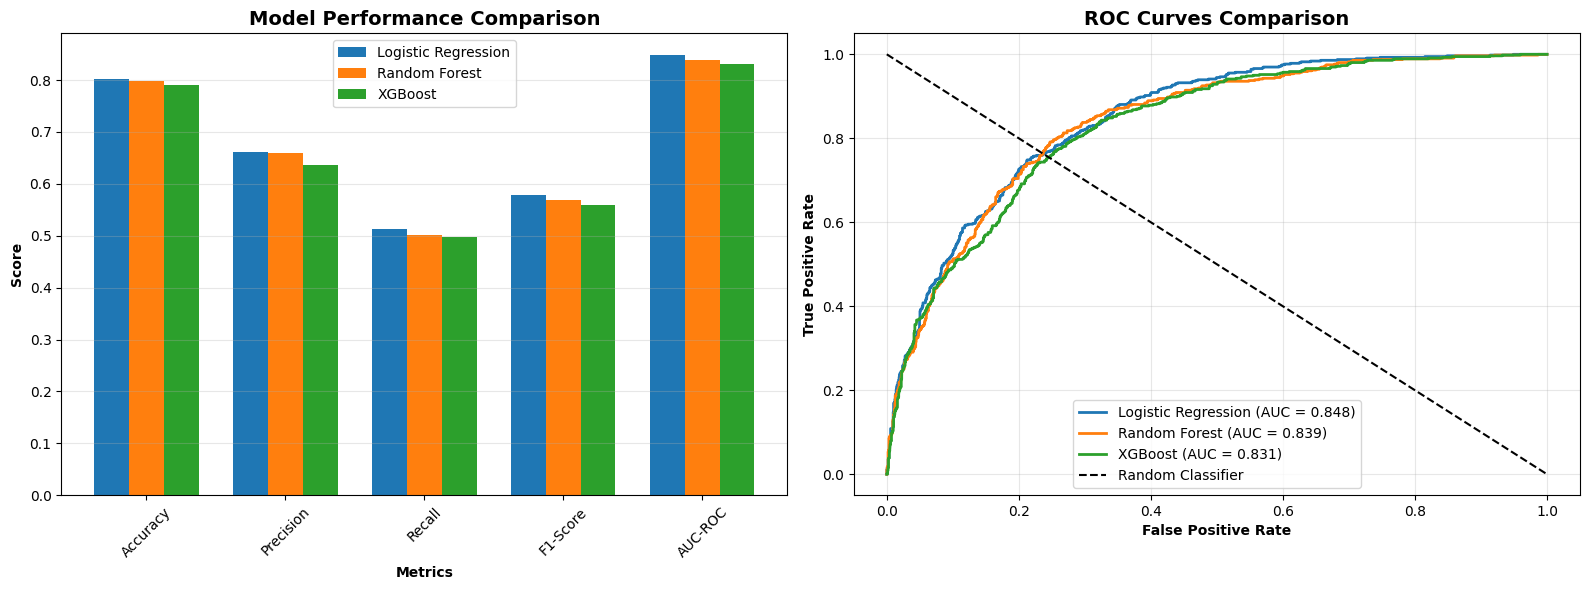


 BEST MODEL: Logistic Regression
 AUC-ROC Score : 0.8477


In [5]:
# Model Comparison

print("\n" + "="*80)
print('MODEL PERFORMANCE COMPARISON')
print("="*80)

comparison_df= pd.DataFrame ({
    'Model' : list(results.keys()),
    'Accuracy' : [results[m]['accuracy'] for m in results],
    'Precision' : [results[m]['precision'] for m in results],
    'Recall' : [results[m]['recall'] for m in results],
    'F1-Score' : [results[m]['f1'] for m in results],
    'AUC-ROC' : [results[m]['auc'] for m in results]
})

print("\n" , comparison_df.to_string(index=False))

# visualize model comparison
fig, axes= plt.subplots(1,2, figsize=(16, 6))

# Bar plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score','AUC-ROC']
x= np.arange(len(metrics))
width= 0.25

for idx, model in enumerate(results.keys()):
    values = [comparison_df[comparison_df['Model']== model][m].values[0] for m in metrics] 
    axes[0].bar(x + idx*width, values, width, label=model)

axes[0].set_xlabel('Metrics', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')    
axes[0].set_xticks(x+ width)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
for model_name in results.keys():
    fpr , tpr , _ =roc_curve(y_test, results[model_name]['probabilities'])
    auc = results[model_name]['auc']
    axes[1].plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

axes[1].plot ([0,1], [1,0], 'k--', label='Random Classifier') 
axes[1].set_xlabel ('False Positive Rate',fontweight='bold')
axes[1].set_ylabel ('True Positive Rate', fontweight='bold') 
axes[1].set_title ('ROC Curves Comparison', fontsize=14, fontweight='bold') 
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Model_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_name= comparison_df.loc[comparison_df['AUC-ROC'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print (f"\n BEST MODEL: {best_model_name}")
print (f" AUC-ROC Score : {results[best_model_name]['auc']:.4f}")



FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important features:
                       Feature  Importance
   InternetService_Fiber optic    0.828169
               AvgMonthlyValue    0.818798
             Contract_Two year    0.689859
                        tenure    0.507412
            CustomerValueScore    0.391149
                  TotalCharges    0.376648
           StreamingMovies_Yes    0.324037
             Contract_One year    0.315046
             MultipleLines_Yes    0.282262
               StreamingTV_Yes    0.269891
              PaperlessBilling    0.205888
PaymentMethod_Electronic check    0.154902
                MonthlyCharges    0.151324
                  ServiceCount    0.132504
         TenureCatrgory_Mature    0.122690


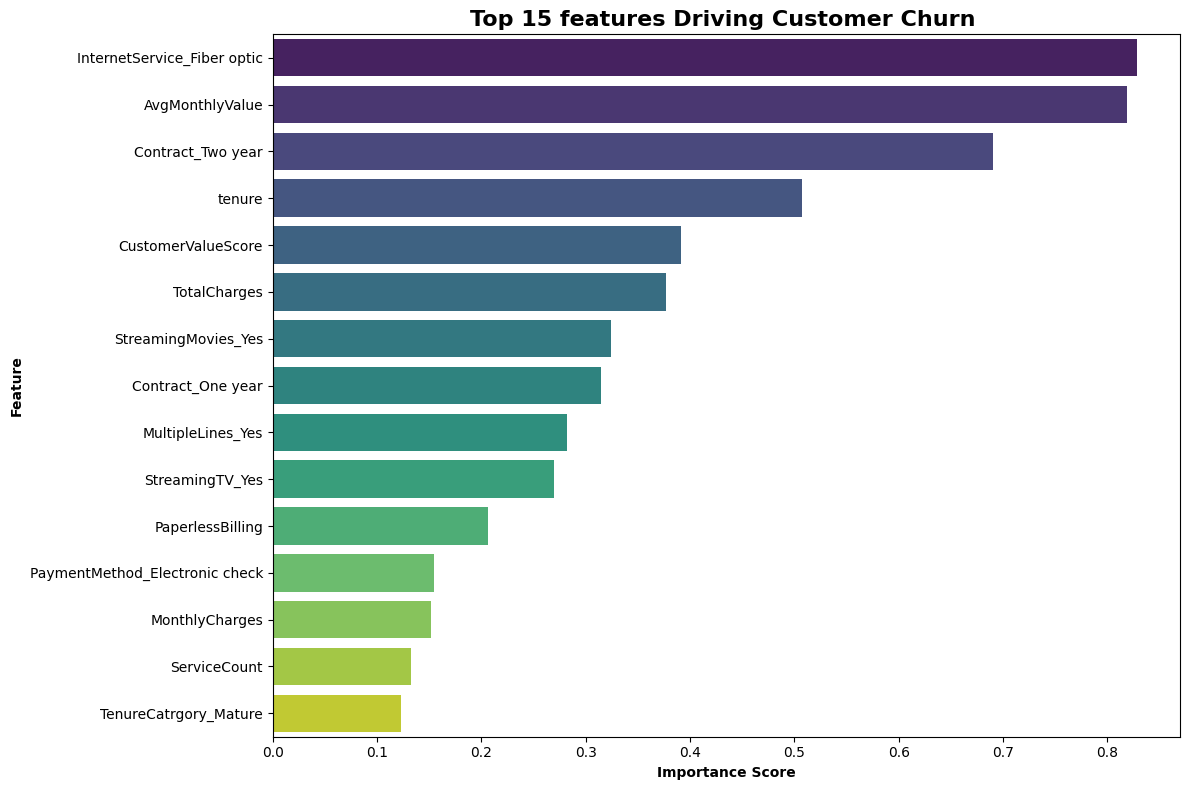

In [6]:
# Feature Importance Analysis

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from best model
if best_model_name == 'Logistic Regression':
    importances= np.abs(best_model.coef_[0])
else:
    importances = best_model.feature_importances_ 

# Create feature importance dataframe
feature_importance= pd.DataFrame ({
    'Feature' : X. columns,
    'Importance' : importances
}).sort_values ('Importance', ascending=False)  

print("\nTop 15 Most Important features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12,8))
sns.barplot(data= feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 features Driving Customer Churn ', fontsize=16, fontweight='bold')
plt.xlabel ('Importance Score', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


BUSINESS IMPACT ANALYSIS


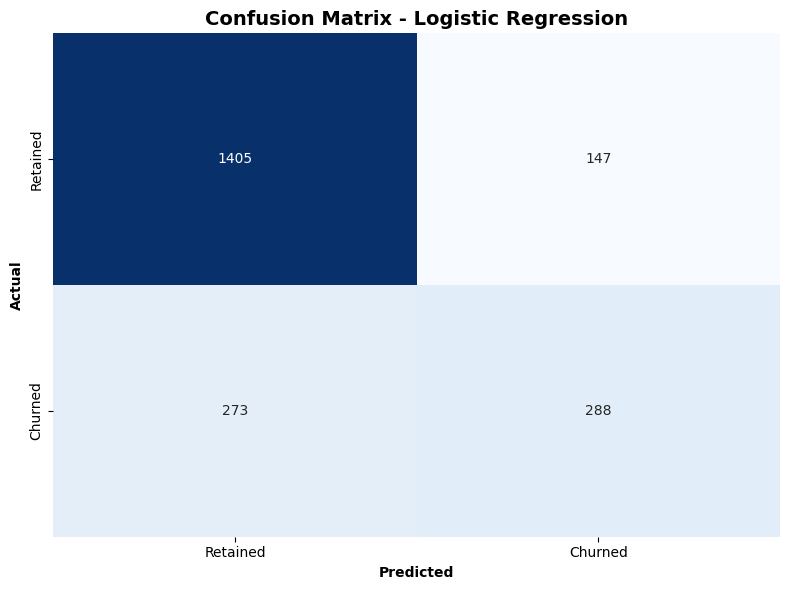


Confusion Matrix Breakdown:
 True Negatives(Correctly predicted retention): 1405
 False Positives(Predicted churn, actually retained): 147
 False Ngatives (Predicted retention, actually churned):273
 True Positives (Correctly Predicted Churn): 288

 FINANCIAL IMPACT(Annual):
 Potention Revenue Saved (True Positives): $223,816.41
 Wasted Retention Spend(False Positives): $14,700.00
 Missed Revenue (False Negatives): $212,159.30
 Net Benefit : $-3,042.90


In [7]:
# Confusion Matrix And Business Metrics

print("\n" + "="*80) 
print('BUSINESS IMPACT ANALYSIS')
print("="*80)

# Confusion Matrix
cm= confusion_matrix(y_test, results[best_model_name]['predictions'])

plt.figure(figsize=(8,6))
sns.heatmap (cm, annot=True, fmt='d',cmap='Blues', cbar=False,
             xticklabels=['Retained','Churned'],
             yticklabels=['Retained', 'Churned'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Business Impact Calculations
tn, fp, fn, tp = cm.ravel()

print (f"\nConfusion Matrix Breakdown:")
print (f" True Negatives(Correctly predicted retention): {tn}")
print (f" False Positives(Predicted churn, actually retained): {fp}")
print (f" False Ngatives (Predicted retention, actually churned):{fn}")
print (f" True Positives (Correctly Predicted Churn): {tp}")

# Financial Impact
avg_customer_value = df['MonthlyCharges'].mean() *12 #Annual value
retention_cost = 100  #Cost to retain a customer 
potential_saves = tp * avg_customer_value
wasted_retention_spend= fp * retention_cost
missed_revenue = fn*avg_customer_value

print (f"\n FINANCIAL IMPACT(Annual):")
print (f" Potention Revenue Saved (True Positives): ${potential_saves:,.2f}")
print (f" Wasted Retention Spend(False Positives): ${wasted_retention_spend:,.2f}")
print (f" Missed Revenue (False Negatives): ${missed_revenue:,.2f}")
print (f" Net Benefit : ${(potential_saves-wasted_retention_spend-missed_revenue):,.2f}")


In [8]:
# Customer Segmentation for Targeted Retention

print("\n" + "="*80) 
print("CUSTOMER SEGMENTATION AND RETENTION STRATEGY")
print("="*80)

# Create risk scores for all customers
X_full_scaled = scaler.transform(X) if best_model_name == 'Logistic Regression' else X
churn_probabilities = best_model.predict_proba (X_full_scaled)[:,1]

# Add to original dataframe
df_strategy = df.copy()
df_strategy['ChurnRisk'] = churn_probabilities

# Segment customers by risk
df_strategy['RiskSegment'] = pd.cut(df_strategy['ChurnRisk'],
                                      bins=[0,0.3, 0.7, 1.0],
                                      labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Count by Segment
risk_segments = df_strategy['RiskSegment'].value_counts()
print("\nCustomer Risk Segmentation:")
for segment in ['High Risk', 'Medium Risk', 'Low Risk']:
    count = risk_segments[segment]
    percentage = (count / len(df_strategy)) * 100
    print (f" {segment} : {count:,} customers ({percentage:.1f}%)")

# High-risk customer profile
high_risk= df_strategy[df_strategy['RiskSegment'] == 'High Risk']  
print (f"\n HIGH RISK CUSTOMER PROFILE (n={len(high_risk)}):")  
print (f" Avg Monthly Charges: ${high_risk['MonthlyCharges'].mean():.2f}")
print (f" Avg Tenure : {high_risk['tenure'].mean():.1f} months ")
print (f" Most Common Contract: {high_risk['Contract'].mode()[0]}")
print (f" Most Common Payment: {high_risk['PaymentMethod'].mode()[0]}")



CUSTOMER SEGMENTATION AND RETENTION STRATEGY

Customer Risk Segmentation:
 High Risk : 559 customers (7.9%)
 Medium Risk : 2,055 customers (29.2%)
 Low Risk : 4,429 customers (62.9%)

 HIGH RISK CUSTOMER PROFILE (n=559):
 Avg Monthly Charges: $81.56
 Avg Tenure : 3.7 months 
 Most Common Contract: Month-to-month
 Most Common Payment: Electronic check


In [9]:
# Save Model and Results

# save high-risk customers to CSV for marketing team
high_risk_export = df_strategy[df_strategy['RiskSegment'] == 'High Risk'][
    ['customerID', 'ChurnRisk','tenure','MonthlyCharges', 'Contract','PaymentMethod']
].copy()
high_risk_export.to_csv('high_risk_customers_for_retention.csv', index=False)
print ("Saved: high_risk_customers_for_retention.csv")

# Save model comparison
comparison_df.to_csv('model_performance_comparison.csv', index=False)
print("Saved : model_performance_comparison.csv")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print ("Saved: feature_importance.csv")

Saved: high_risk_customers_for_retention.csv
Saved : model_performance_comparison.csv
Saved: feature_importance.csv
